# L4-C - Building your own Quantizer: Quantize any Open Source PyTorch Model

In this lesson, you will look at the results of open source models compressed using the custom quantizer you built.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Building your own Quantizer` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from helper import W8A16LinearLayer, replace_linear_with_target_and_quantize

## Step 3: Test the Implementation on Various LLMs

### 3.1 - [Salesforce/codegen-350M-mono](https://huggingface.co/Salesforce/codegen-350M-mono)

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "../MODELS/Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(model_id, 
                                    torch_dtype=torch.bfloat16, 
                                             low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of the model checkpoint at ../MODELS/Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another archi

In [3]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [4]:
print(pipe("def hello_world():", max_new_tokens=20, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': 'def hello_world():\n    print("Hello World!")\n\nhello_world()\n\n# �'}]


In [5]:
print("Model before:\n\n", model)

Model before:

 CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bi

In [6]:
replace_linear_with_target_and_quantize(model, 
                                        W8A16LinearLayer, ["lm_head"])

In [7]:
pipe.model

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)

In [8]:
print(pipe("def hello_world():", max_new_tokens=20, 
           do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


def hello_world():
    print("Hello World")

# hello_world()

# def hello_


### 3.2 - [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

In [9]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")

In [11]:
previous_memory_footprint = model.get_memory_footprint()

In [12]:
print("Footprint of the model in MBs: ", 
      previous_memory_footprint/1e+6)

Footprint of the model in MBs:  166.524032


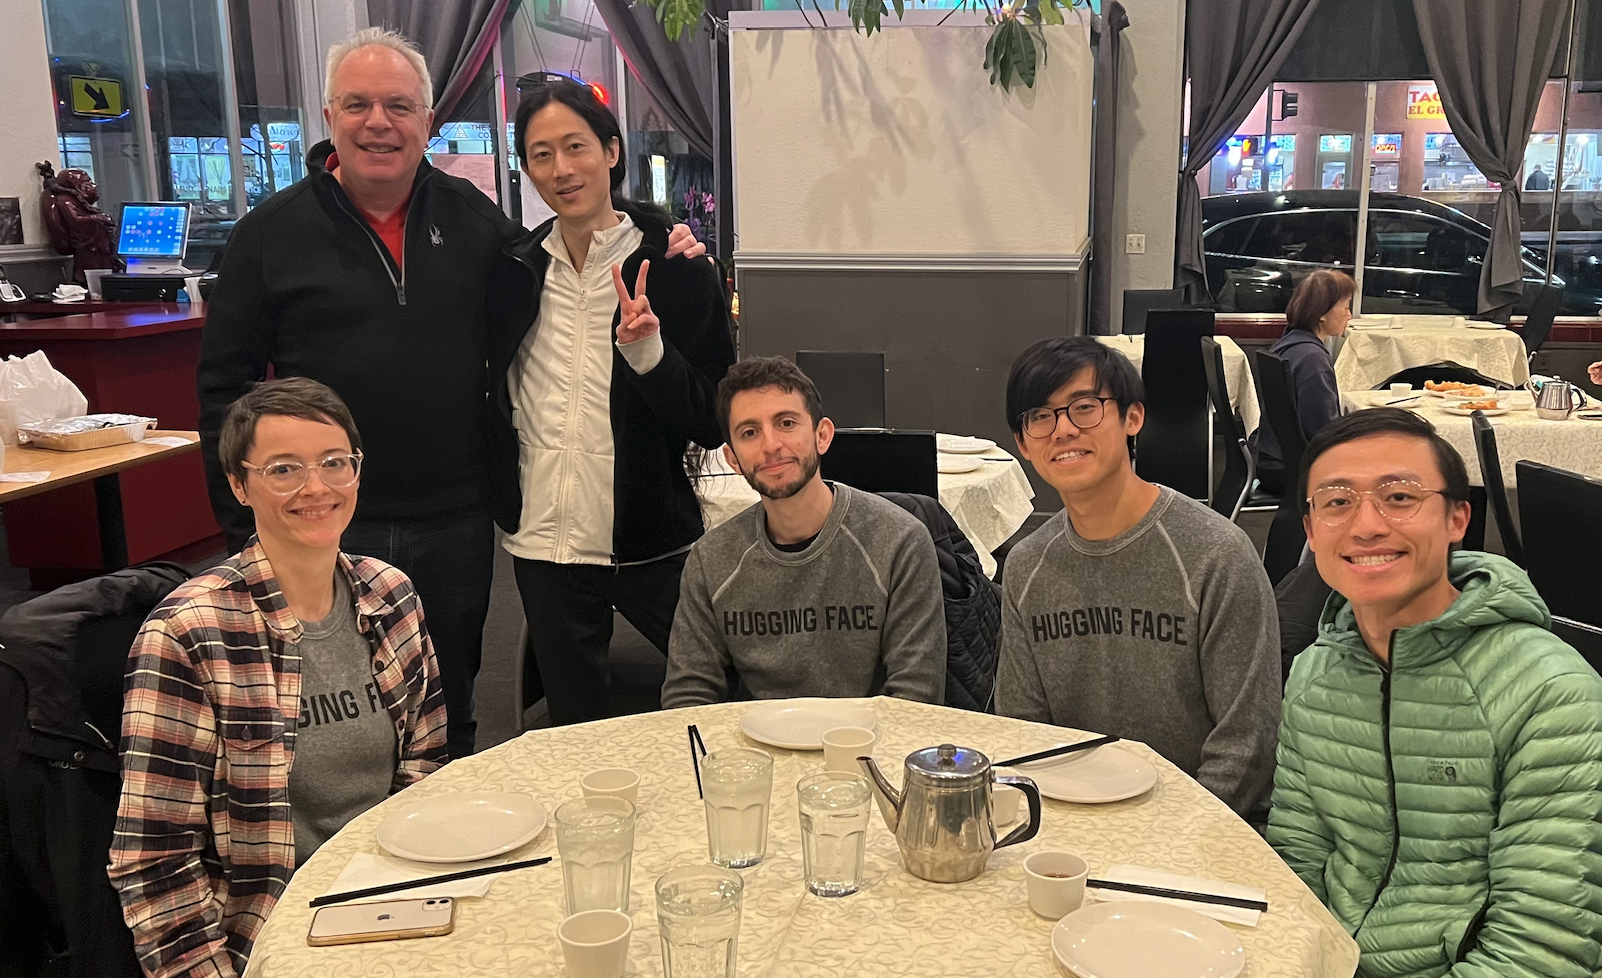

In [13]:
img_path = "dinner_with_friends.png"
image = Image.open(img_path).convert("RGB")
image

In [14]:
from helper import plot_results

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

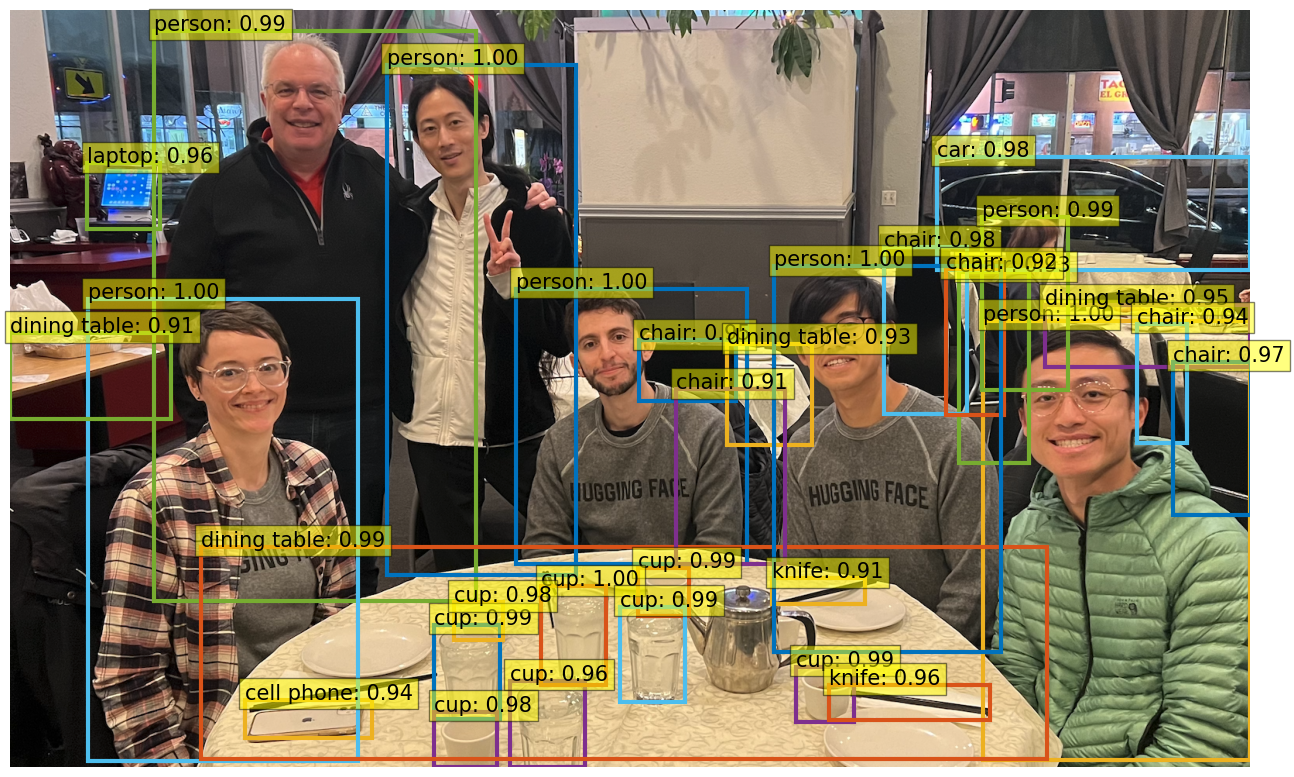

In [15]:
plot_results(model, image, results)

In [16]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [25]:
replace_linear_with_target_and_quantize(model, 
                                        W8A16LinearLayer, 
               ["0", "1", "2", "class_labels_classifier"])

In [26]:
### Model after quantization
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

- Visualize results after quantization.

In [27]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

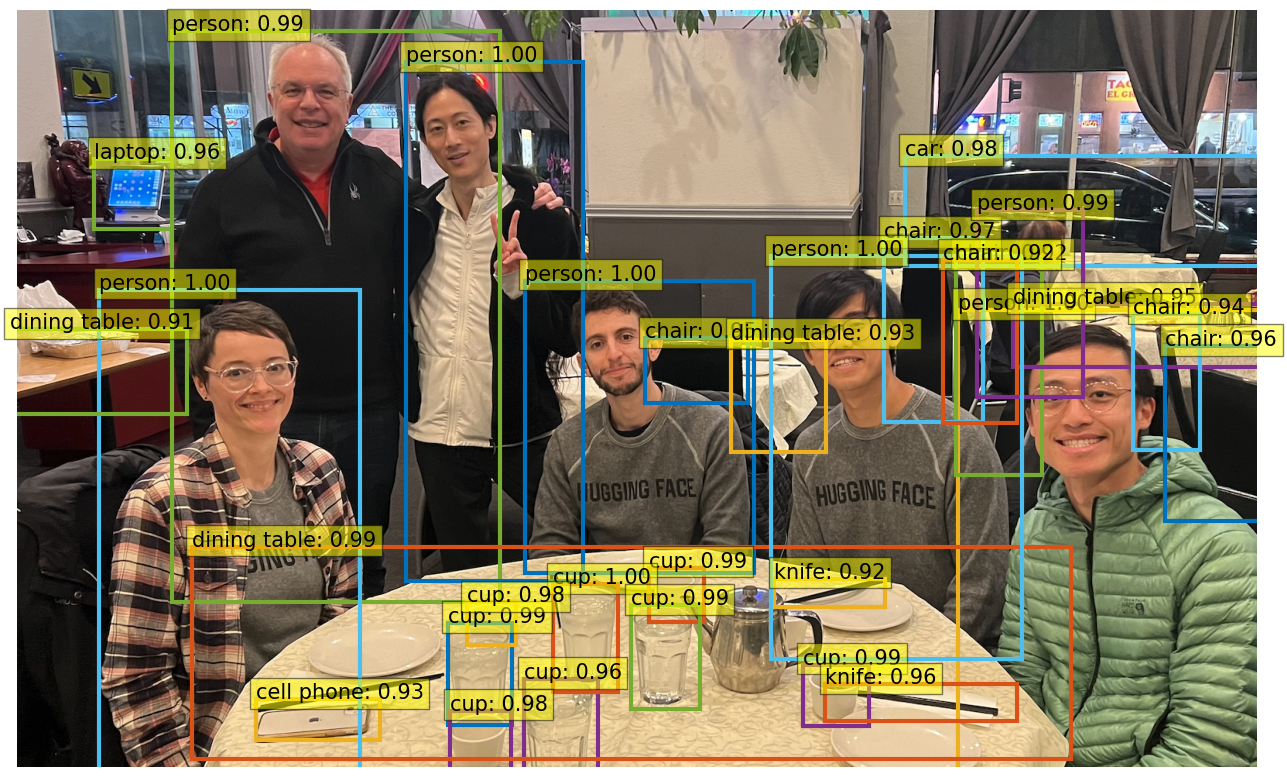

In [28]:
plot_results(model, image, results)

In [29]:
new_footprint = model.get_memory_footprint()

In [30]:
print("Footprint of the model in MBs: ", 
      new_footprint/1e+6)

Footprint of the model in MBs:  114.339328


In [31]:
### Memory saved
print("Memory saved in MBs: ", 
      (previous_memory_footprint - new_footprint)/1e+6)

Memory saved in MBs:  52.184704
